In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'mejiro':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

from mejiro.lenses import sample_skypy_lens
from mejiro.plots import diagnostic_plot, plot

plt.style.use(f'{repo_path}/mejiro/mplstyle/science.mplstyle')

In [3]:
figure_dir = os.path.join(repo_path, 'figures')
array_dir = os.path.join(repo_path, 'output', 'arrays')

# Generate images with various PSFs

In [4]:
lens = sample_skypy_lens.SampleSkyPyLens()

num_pix = 51
side = 5.61
band = 'f106'

## No PSF

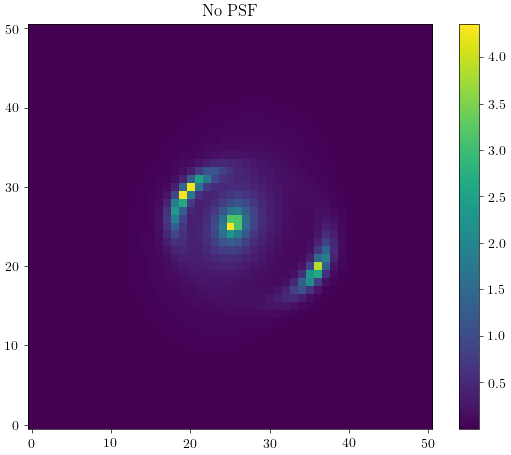

(51, 51)


In [5]:
kwargs_psf_none = {'psf_type': 'NONE'}

no_psf = lens.get_array(num_pix=num_pix, kwargs_psf=kwargs_psf_none, side=side)

plot.plot(title='No PSF',
          array=no_psf,
          colorbar=True)

print(no_psf.shape)

## Gaussian PSF

I'm getting the PSF FWHM values from [here](https://roman.gsfc.nasa.gov/science/WFI_technical.html). From that webpage: "Note: PSF FWHM in arcseconds simulated at the center of the center pixel of a detector near the center of the WFI FOV using an input spectrum for a K0V type star."

In [6]:
psf_fwhm = {
    'f062': 0.058,
    'f087': 0.073,
    'f106': 0.087,
    'f129': 0.105,
    'f158': 0.127,
    'f184': 0.151,
    'f213': 0.175,
    'f146': 0.105
}

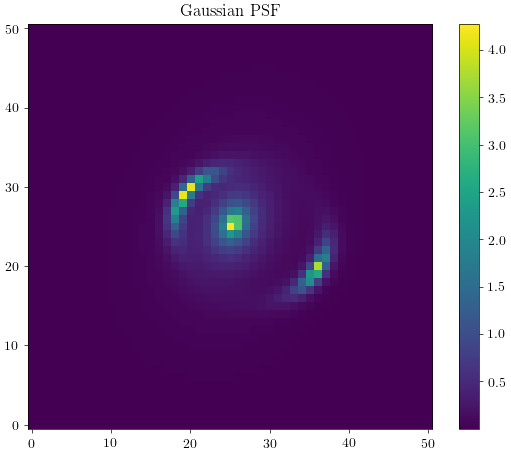

(51, 51)


In [7]:
kwargs_psf_gaussian = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm.get(band)}

gaussian_psf = lens.get_array(num_pix=num_pix, kwargs_psf=kwargs_psf_gaussian, side=side)

plot.plot(title='Gaussian PSF',
          array=gaussian_psf,
          colorbar=True)

print(gaussian_psf.shape)

## `lenstronomy` Roman module, which uses a pixel PSF

Not sure where they got the PSFs and under what conditions they were generated, but they're `.fits` files

In [8]:
pixel_psf, _, _ = lens.get_roman_sim(noise=False)

plot.plot(title='Pixel PSF from Lenstronomy Roman module',
          array=pixel_psf,
          colorbar=True)

print(pixel_psf.shape)

AttributeError: 'SampleSkyPyLens' object has no attribute 'get_roman_sim'

# Compare

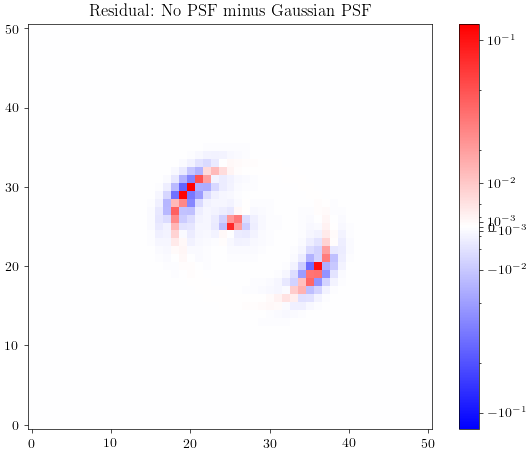

In [9]:
diagnostic_plot.residual(no_psf, gaussian_psf, title='Residual: No PSF minus Gaussian PSF')

In [10]:
diagnostic_plot.residual(no_psf, pixel_psf, title='Residual: No PSF minus pixel PSF')

NameError: name 'pixel_psf' is not defined

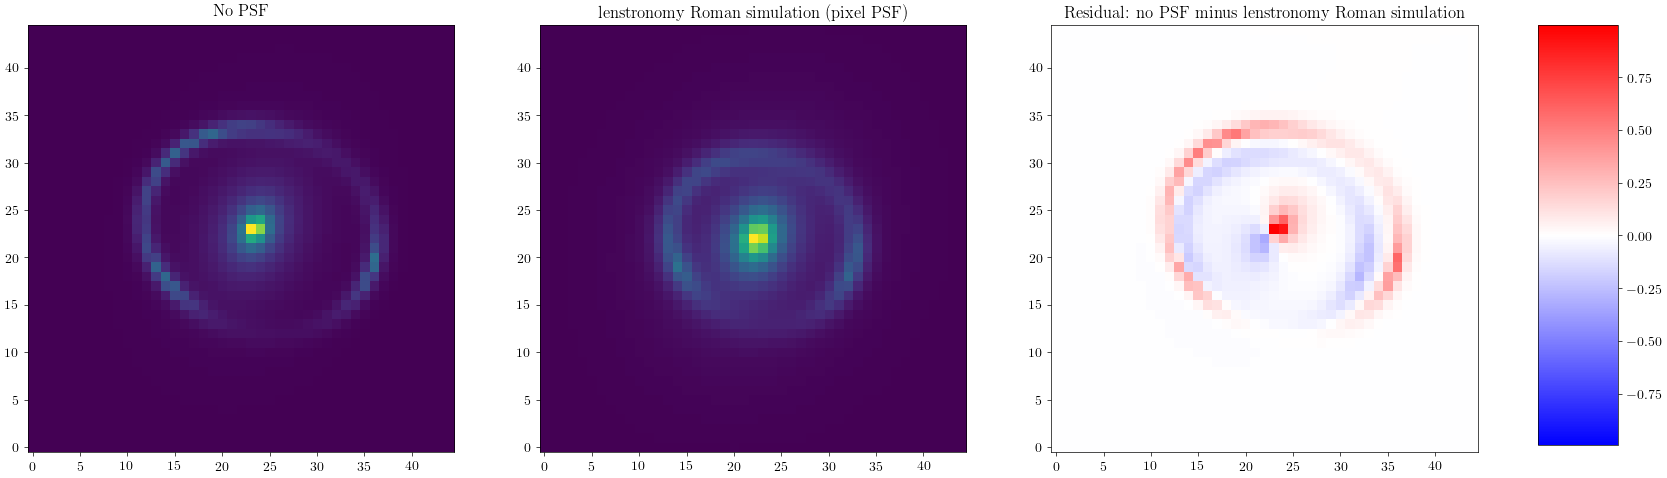

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

residual = no_psf - pixel_psf
abs_min, abs_max = abs(np.min(residual)), abs(np.max(residual))
limit = np.max([abs_min, abs_max])

im0 = axes[0].imshow(no_psf)
im1 = axes[1].imshow(pixel_psf)
im2 = axes[2].imshow(residual, vmin=-limit, vmax=limit, cmap='bwr')

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

axes[0].set_title('No PSF')
axes[1].set_title('lenstronomy Roman simulation (pixel PSF)')
axes[2].set_title('Residual: no PSF minus lenstronomy Roman simulation')

plt.show()

# Combine

In [ ]:
pandeia = np.load(os.path.join(array_dir, 'no_noise_or_background', 'detector_no_noise_or_background_9.npy'))

In [ ]:
def get_norm(array_list):
    min_list, max_list = [], []
    for array in array_list:
        min_list.append(abs(np.min(array)))
        max_list.append(abs(np.max(array)))
    abs_min, abs_max = abs(np.min(min_list)), abs(np.max(max_list))
    limit = np.max([abs_min, abs_max])
    linear_width = np.abs(np.mean(np.concatenate(array_list)) + (0 * np.std(np.concatenate(array_list))))
    return colors.AsinhNorm(linear_width=0.0005, vmin=-limit, vmax=limit)

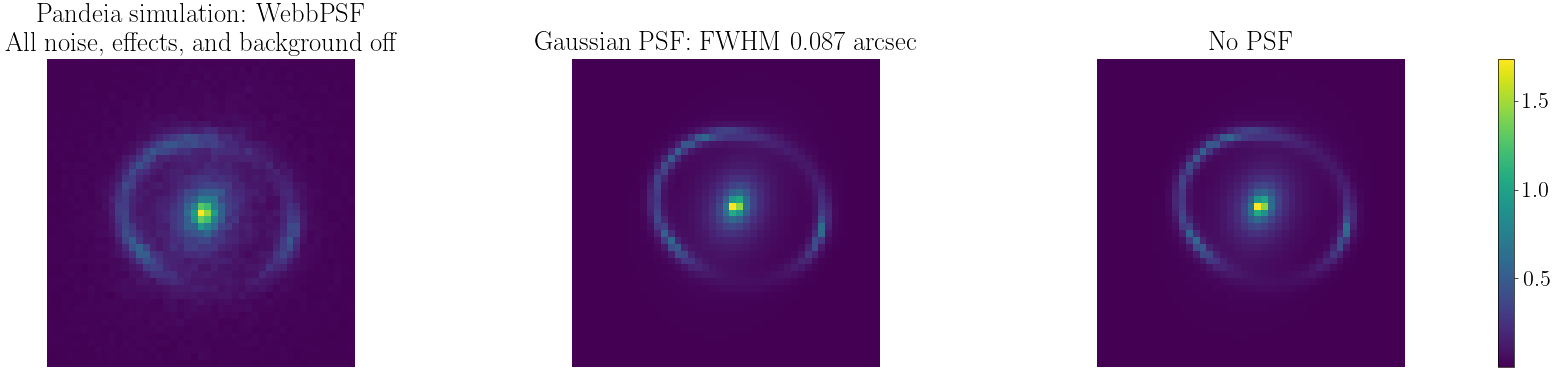

In [ ]:


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 4))
matplotlib.rcParams.update({'font.size': 16})

array_list = [pandeia, gaussian_psf, no_psf]
title_list = ['Pandeia simulation: WebbPSF\nAll noise, effects, and background off', f'Gaussian PSF: FWHM {psf_fwhm.get(band)} arcsec', 'No PSF']

norm = get_norm(array_list)

for i, array in enumerate(array_list):
    axis = ax[i].imshow(array, cmap='viridis')
    ax[i].set_title(title_list[i])
    ax[i].set_axis_off()

fig.colorbar(axis, ax=ax)

plt.savefig(os.path.join(figure_dir, 'psf_compare_1.png'))
plt.show()

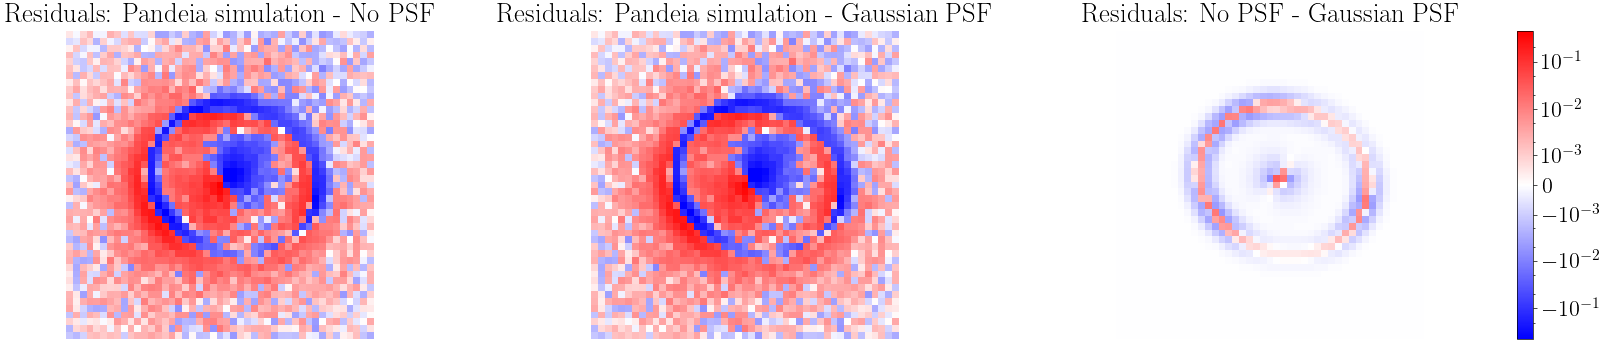

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 4))
matplotlib.rcParams.update({'font.size': 16})

array_list = [pandeia - no_psf, pandeia - gaussian_psf, no_psf - gaussian_psf]
title_list = ['Residuals: Pandeia simulation - No PSF', 'Residuals: Pandeia simulation - Gaussian PSF', 'Residuals: No PSF - Gaussian PSF']

norm = get_norm(array_list)

for i, array in enumerate(array_list):
    axis = ax[i].imshow(array, cmap='bwr', norm=get_norm(array_list))
    ax[i].set_title(title_list[i])
    ax[i].set_axis_off()

fig.colorbar(axis, ax=ax, ticks=[-0.1, -0.01, -0.001, 0, 0.001, 0.01, 0.1])

plt.savefig(os.path.join(figure_dir, 'psf_compare_2.png'))
plt.show()